# Reproducing results from Kaye *et al.*, 2024

Here, we use climepi to reproduce results from Kaye *et al.*, *Lancet Planet Health*,
2024 (https://doi.org/10.1016/S2542-5196(24)00238-9). Note that the results here differ
slightly from those presented in the paper due to differences in the inference
implementation.

**Note: Running the code in step 3 will trigger the download of ~1.1 GB of climate
projection data.**

In [ ]:
import bokeh.palettes
import numpy as np
import pymc as pm

import climepi  # noqa
from climepi import climdata, epimod

try:
    import arviz.preview as az
except ImportError:
    import arviz as az

## 1. Fitting *Aedes aegypti* temperature responses

(For details of suitability model parameterisation in climepi, see the documentation for
the
[ParameterizedSuitabilityModel](../generated/climepi.epimod.ParameterizedSuitabilityModel.rst)
class).

First, we retrieve temperature-dependent *Ae. aegypti* trait data collated by Mordecai
*et al.*, PLOS Negl Trop Dis, 2017 (https://doi.org/10.1371/journal.pntd.0005568),
available as an example dataset in the `epimod` subpackage.

In [2]:
data = epimod.get_example_temperature_response_data("mordecai_ae_aegypti")
data

,trait_name,temperature,trait_value,reference
0,egg_to_adult_survival_probability,22.0,0.908120,Westbrook_Thesis_2010
1,egg_to_adult_survival_probability,27.0,0.935900,Westbrook_Thesis_2010
2,egg_to_adult_survival_probability,32.0,0.819440,Westbrook_Thesis_2010
3,egg_to_adult_development_rate,22.0,0.091740,Westbrook_Thesis_2010
4,egg_to_adult_development_rate,27.0,0.135870,Westbrook_Thesis_2010
...,...,...,...,...
207,human_to_mosquito_transmission_probability,20.0,0.184000,Carrington_et_al_2013_PNTD
208,human_to_mosquito_transmission_probability,30.0,0.640000,Carrington_et_al_2013_PNTD
209,human_to_mosquito_transmission_probability,35.0,0.520000,Carrington_et_al_2013_PNTD
210,extrinsic_incubation_rate,30.0,0.193798,Carrington_et_al_2013_PNTD


We then define a suitability function, here returning a binary output indicating
whether a nonzero mosquito population can be sustained given the input mosquito life
history traits. For details of the modelling approach, see Kaye *et al.*, 2024.

In [3]:
def suitability_function(
    eggs_per_female_per_day=None,
    egg_to_adult_development_rate=None,
    egg_to_adult_survival_probability=None,
    adult_lifespan=None,
    aquatic_stage_carrying_capacity_per_m2=None,
    larval_flush_out_rate=None,
):
    """Suitability function for Ae. aegypti from Kaye et al., 2024."""
    aquatic_to_adult_development_rate = (73 / 48) * egg_to_adult_development_rate
    aquatic_stage_death_rate = aquatic_to_adult_development_rate * (
        (1 / egg_to_adult_survival_probability) - 1
    )
    equilibrium_density = aquatic_stage_carrying_capacity_per_m2 * (
        0.5 * aquatic_to_adult_development_rate * adult_lifespan
        - (
            larval_flush_out_rate
            + aquatic_stage_death_rate
            + aquatic_to_adult_development_rate
        )
        / eggs_per_female_per_day
    )
    suitability = equilibrium_density > 0
    return suitability

Finally, we define a dictionary characterising the dependencies of trait parameters on
environmental variables. Each value is the name of a trait parameter, and each key is
one of the following:
- For temperature-dependent traits to be fitted to data, a dictionary describing the
assumed functional form of the response curve (either Briere or bounded quadratic),
priors for parameters of the response curve (defined as callables returning
[pymc](https://www.pymc.io/) distributions), and any trait attributes (the 'long_name'
and 'units' fields are used to automatically label axes in plots).
- A callable with keyword arguments 'temperature' and 'precipitation' defining a
specified response function.
- A scalar value for a fixed parameter.

In [4]:
parameters = {
    "eggs_per_female_per_day": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma("scale", alpha=2, beta=100),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=10, beta=1 / 2
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=10, beta=1 / 4
            ),
            "noise_std": lambda: pm.Uniform("noise_std", lower=0, upper=10),
        },
        "attrs": {"long_name": "Eggs per female per day"},
    },
    "egg_to_adult_development_rate": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma("scale", alpha=9, beta=100000),
            "temperature_min": lambda: pm.Gamma("temperature_min", alpha=7, beta=1 / 2),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=10, beta=1 / 4
            ),
            "noise_std": lambda: pm.Uniform("noise_std", lower=0, upper=1),
        },
        "attrs": {"long_name": "Egg to adult development rate", "units": "per day"},
    },
    "egg_to_adult_survival_probability": {
        "curve_type": "quadratic",
        "probability": True,
        "priors": {
            "scale": lambda: pm.Gamma("scale", alpha=7, beta=1000),
            "temperature_min": lambda: pm.Gamma("temperature_min", alpha=7, beta=1 / 2),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=10, beta=1 / 4
            ),
            "noise_std": lambda: pm.Uniform("noise_std", lower=0, upper=5),
        },
        "attrs": {"long_name": "Egg to adult survival probability"},
    },
    "adult_lifespan": {
        "curve_type": "quadratic",
        "priors": {
            "scale": lambda: pm.Gamma("scale", alpha=1, beta=2),
            "temperature_min": lambda: pm.Gamma("temperature_min", alpha=5, beta=1 / 2),
            "temperature_max": lambda: pm.Gamma("temperature_max", alpha=9, beta=1 / 5),
            "noise_std": lambda: pm.Uniform("noise_std", lower=0, upper=50),
        },
        "attrs": {
            "long_name": "Adult lifespan",
            "units": "days",
        },
    },
    "aquatic_stage_carrying_capacity_per_m2": lambda temperature=None,
    precipitation=None: (precipitation >= 0.2)
    * precipitation
    * 300
    / (25 * 4.59 * (5 + 245 + precipitation)),
    "larval_flush_out_rate": lambda temperature=None, precipitation=None: (
        precipitation
    ),
}

We now create a `ParameterizedSuitabilityModel` instance with the specified suitability
function, parameter dictionary and data, and use the `fit_temperature_responses()`
method to fit the temperature response curves.

In [5]:
suitability_model = epimod.ParameterizedSuitabilityModel(
    parameters=parameters, data=data, suitability_function=suitability_function
)
idata_dict = suitability_model.fit_temperature_responses(tune=10000, draws=25000)

Fitting temperature response for parameter: eggs_per_female_per_day


Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:28,615 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:28,615 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:28,617 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:28,617 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.
2025-10-28 17:32:34,032 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.
2025-10-28 17:32:34,032 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.


Fitting temperature response for parameter: egg_to_adult_development_rate


Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:39,341 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:39,341 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:39,342 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:39,342 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-10-28 17:32:45,114 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-10-28 17:32:45,114 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: egg_to_adult_survival_probability


Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:52,424 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:32:52,424 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:52,426 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:32:52,426 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-10-28 17:32:58,054 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-10-28 17:32:58,054 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: adult_lifespan


Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:33:05,029 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-10-28 17:33:05,029 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:33:05,031 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]
2025-10-28 17:33:05,031 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_std]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.
2025-10-28 17:33:10,477 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.
2025-10-28 17:33:10,477 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 5 seconds.


Each entry of `idata_dict` is an [arviz](https://arviz.dev/) `InferenceData` object,
which can be used with arviz for inference diagnostics and plots. For example, we plot
traces of fitted response curve parameters for the 'eggs_per_female_per_day' trait, and
compute R-hat and effective sample size values.

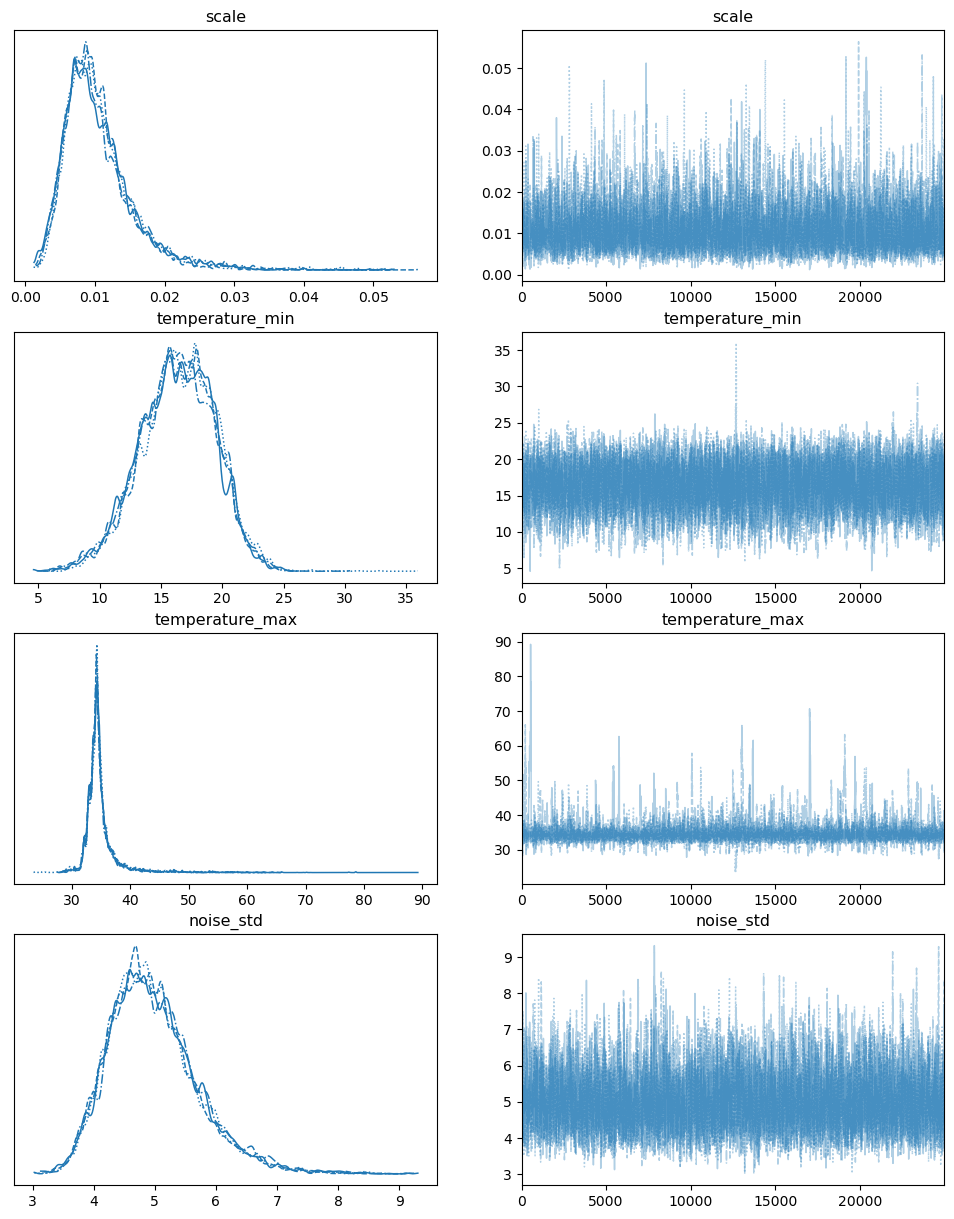

In [6]:
az.plot_trace(idata_dict["eggs_per_female_per_day"], figsize=(12, 15));

In [7]:
for parameter_name, idata in idata_dict.items():
    print(f"Trait '{parameter_name}'")
    rhat = az.rhat(idata)
    ess = az.ess(idata)
    print(
        f"\tR-hat values: {rhat.scale.item():.3f} (scale), "
        f"{rhat.temperature_min.item():.3f} (min temp), "
        f"{rhat.temperature_max.item():.3f} (max temp), "
        f"{rhat.noise_std.item():.3f} (noise std)"
    )
    print(
        f"\tEffective sample size values: {ess.scale.item():.0f} (scale), "
        f"{ess.temperature_min.item():.0f} (min temp), "
        f"{ess.temperature_max.item():.0f} (max temp), "
        f"{ess.noise_std.item():.0f} (noise std)"
    )

Trait 'eggs_per_female_per_day'
	R-hat values: 1.002 (scale), 1.001 (min temp), 1.002 (max temp), 1.002 (noise std)
	Effective sample size values: 3332 (scale), 4660 (min temp), 3166 (max temp), 4287 (noise std)
Trait 'egg_to_adult_development_rate'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.001 (max temp), 1.000 (noise std)
	Effective sample size values: 5847 (scale), 5725 (min temp), 6179 (max temp), 6085 (noise std)
Trait 'egg_to_adult_survival_probability'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.000 (max temp), 1.001 (noise std)
	Effective sample size values: 6386 (scale), 6695 (min temp), 6631 (max temp), 6527 (noise std)
Trait 'adult_lifespan'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.001 (max temp), 1.000 (noise std)
	Effective sample size values: 4837 (scale), 4664 (min temp), 5242 (max temp), 5503 (noise std)


The `plot_fitted_temperature_responses()` method can be used to visualize fitted
temperature responses for each trait. Note that the returned plot object is a
[HoloViews](https://holoviews.org/) `Layout` object. Customizations can be applied to
each panel using the `opts()` method.

In [8]:
plots = suitability_model.plot_fitted_temperature_responses(
    temperature_vals=np.linspace(0, 50, 500), frame_width=300, frame_height=300
).cols(2)
plots[0].opts(ylim=(0, 16), legend_position="top_left")
plots[1].opts(ylim=(0, 0.2), show_legend=False)
plots[2].opts(ylim=(0, 1), show_legend=False)
plots[3].opts(ylim=(0, 50), show_legend=False)
plots

:Layout
   .Overlay.I   :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Eggs per female per day)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.II  :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Egg to adult development rate)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.III :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Egg to adult survival probability)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.IV  :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Adult lifespan)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)

## 2. Constructing the suitability table

Before running the model on climate projection data, we construct the suitability table
describing whether a nonzero vector population can be supported on a grid of temperature
and precipitation values.

Note that we choose the grid of precipitation values such that the cutoff of
0.2 mm/day (below which the aquatic stage carrying capacity is assumed to be zero) lies
in the middle of two grid points. This is because climepi uses nearest-neighbor
interpolation to determine suitability at non-grid points when running a suitability
model on a climate dataset (and therefore this choice of grid ensures the cutoff is
applied exactly).

In [9]:
suitability_model.construct_suitability_table(
    temperature_vals=np.arange(0, 40.1, 0.1),
    precipitation_vals=np.arange(-0.05, 30.1, 0.1),
    num_samples=1000,
)

<xarray.Dataset> Size: 121MB
Dimensions:        (precipitation: 302, temperature: 401, sample: 1000)
Coordinates:
  * precipitation  (precipitation) float64 2kB -0.05 0.05 0.15 ... 29.95 30.05
  * temperature    (temperature) float64 3kB 0.0 0.1 0.2 0.3 ... 39.8 39.9 40.0
  * sample         (sample) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    suitability    (precipitation, temperature, sample) bool 121MB False ... ...

The constructed suitability table includes a dimension 'sample', giving a separate
region of suitable temperature and precipitation values for each posterior sample. To
consider summary statistics, we use the `reduce()` method.

First we use `reduce()` with argument `stat='mean'`, which computes the mean suitability
value across all posterior samples – since we are using a binary suitability metric,
here this corresponds to the posterior probability of suitability at each grid point.
We use the `plot_suitability()` method of the reduced suitability model to visualize
the regions with a 2.5%, 50%, and 97.5% posterior probability of suitability.

In [10]:
suitability_model.reduce(stat="mean").plot_suitability().opts(
    color_levels=[0, 0.025, 0.5, 0.975, 1],
    cmap=["green", "yellow", "orange", "red"],
    clabel="Probability of suitability",
)

:Image   [temperature,precipitation]   (Suitability)

Now, we use `reduce()` with `stat='median'` to obtain a `SuitabilityModel` instance
containing the median suitability table.

In [11]:
median_suitability_model = suitability_model.reduce(stat="median")
median_suitability_model.plot_suitability()

:Image   [temperature,precipitation]   (Suitability)

## 3. Loading climate data

Now, we load monthly global climate projections for 2020 and 2100 from the CESM2 LENS
project. The data are included as an example dataset (stored on the climepi GitHub
repository) accessible via the `get_example_dataset()` method of the `climdata`
subpackage, but can also be downloaded from the original source using
`climdata.get_climate_data()` as follows:
```python
ds_clim = climdata.get_climate_data(
    data_source="lens2",
    frequency="monthly",
    subset={"years": [2020, 2100]},
    download=True,
    save_dir="some/directory",
)
```

**By default, the data are downloaded to the OS cache directory; change the 'base_dir'
argument below to use a different file path.**

In [12]:
ds_clim = climdata.get_example_dataset("lens2_2020_2100_monthly", base_dir=None)
ds_clim

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 24, bnds: 2, scenario: 1, model: 1, realization: 100,
                    lat: 192, lon: 288)
Coordinates:
  * time           (time) object 192B 2020-01-16 12:00:00 ... 2100-12-16 12:0...
  * scenario       (scenario) <U6 24B 'ssp370'
  * model          (model) <U5 20B 'cesm2'
  * realization    (realization) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * lat            (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon            (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    member_id      (realization) <U12 5kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds      (time, bnds) object 384B 2020-01-01 00:00:00 ... 2101-01-0...
    temperature    (scenario, model, realization, time, lat, lon) float32 531MB dask.array<chunksize=(1, 1, 1, 24, 192, 288), meta=np.ndarray>
    precipitation  (scenario, model, realization, time, lat, lon) float32 531MB dask.array<chunksize=(1, 1, 1, 24, 192, 288), meta=np.ndarray>
    lon_bnds       (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
    lat_bnds       (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                       CF-1.0
    NCO:                               netCDF Operators version 4.9.4 (Homepa...
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  month_1
    ...                                ...
    intake_esm_attrs:vertical_levels:  1.0
    intake_esm_attrs:spatial_domain:   global
    intake_esm_attrs:start_time:       1850-01-16 12:00:00
    intake_esm_attrs:end_time:         2014-12-16 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.monthly.cmip6

## 4. Running the ecological model

We use the `climepi` accessor for [xarray](https://xarray.dev/) Datasets to run the
ecological model on on the climate data, obtaining projections of the number of months
suitable for *Ae. aegypti* each year.

In [13]:
ds_months_suitable = ds_clim.climepi.run_epi_model(
    median_suitability_model, return_yearly_portion_suitable=True
)
ds_months_suitable

<xarray.Dataset> Size: 88MB
Dimensions:           (time: 2, scenario: 1, model: 1, realization: 100,
                       lat: 192, lon: 288, bnds: 2)
Coordinates:
  * time              (time) object 16B 2020-07-02 12:00:00 2100-07-02 12:00:00
  * scenario          (scenario) <U6 24B 'ssp370'
  * model             (model) <U5 20B 'cesm2'
  * realization       (realization) int64 800B 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * lat               (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    member_id         (realization) <U12 5kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    portion_suitable  (time, scenario, model, realization, lat, lon) int64 88MB dask.array<chunksize=(2, 1, 1, 1, 192, 288), meta=np.ndarray>
    lat_bnds          (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds          (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
    time_bnds         (time, bnds) object 32B 2020-01-01 00:00:00 ... 2101-01...

## 5. Visualizing the results

We now reproduce Figure 2 from Kaye *et al.*, 2024, which shows the expected change in
the number of months suitable (over the 100 CESM simulations) between 2020 and 2100.

In [14]:
ds_mean_change = (
    ds_months_suitable.isel(time=1) - ds_months_suitable.isel(time=0)
).mean(dim="realization")
ds_mean_change.climepi.plot_map(
    clim=(-12, 12),
    cmap=["blue"] * 11 + ["white"] * 2 + ["red"] * 11,
    clabel="Change in months suitable",
)

:Overlay
   .Image.I     :Image   [lon,lat]   (portion_suitable)
   .Coastline.I :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Lakes.I     :Feature   [Longitude,Latitude]

Finally, we reproduce Figure 3 from the paper, which shows the max/min months suitable
in 2100 across the 100 CESM simulations, and the difference between these.

In [15]:
ds_max_2100 = ds_months_suitable.isel(time=1).max(dim="realization")
ds_min_2100 = ds_months_suitable.isel(time=1).min(dim="realization")
cmap = ("#ffffff",) * 2 + bokeh.palettes.viridis(256)  # show white for values of zero
p_max = ds_max_2100.climepi.plot_map(cmap=cmap, title="Maximum months suitable")
p_min = ds_min_2100.climepi.plot_map(cmap=cmap, title="Minimum months suitable")
p_diff = (ds_max_2100 - ds_min_2100).climepi.plot_map(
    cmap=cmap, title="Difference between maximum and minimum months suitable"
)
(p_max + p_min + p_diff).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Image.I     :Image   [lon,lat]   (portion_suitable)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
      .Ocean.I     :Feature   [Longitude,Latitude]
      .Lakes.I     :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Image.I     :Image   [lon,lat]   (portion_suitable)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
      .Ocean.I     :Feature   [Longitude,Latitude]
      .Lakes.I     :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Image.I     :Image   [lon,lat]   (portion_suitable)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
      .Ocean.I     :Feature   [Longitude,Latitude]
      .Lakes.I     :Feature   [Longitude,Latitude]